In [1]:
#This classification model cuts all rows where nan values are present in the column "Review Score Rating"
#This is the most accurate classification model (becasue I cut rid of some of the Review Score Rating)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)    #removes all red warnings

class color:           # lets me bold text
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

#loading the dataset
dataset = pd.read_csv('AirbnbMNdata-Classification.csv')
dataset["host_total_listings_count"] = dataset["host_total_listings_count"].replace(0,1)     # All 0's have a bed listed
dataset["beds"] = dataset["beds"].replace(0,1)     #All beds with 0 have some sort of bed listed
dataset["bed_type"] = dataset["bed_type"].replace(['Airbed','Couch','Futon','Pull-out Sofa'],'other')
dataset["bedrooms"] = dataset["bedrooms"].replace(0,dataset["accommodates"]/2).apply(np.ceil)     #Assume 2 people per bedroom
dataset["property_type"] = dataset["property_type"].replace(['Castle','Other','Villa'],"other_under_1000")    #Simplifies property type category by price
dataset["property_type"] = dataset["property_type"].replace(['barn','Bed and breakfast','Bungalow','Boat','Boutique Hotel',
    'Campsite','Cabin','Camper/RV','Chalet','Cottage','Earth house','Dome house','Farm stay','Guest suite','Guesthouse',
    'Hostel','Hotel','Houseboat','Island','Loft','Nature lodge','Plane','Resort','Serviced apartment','Tiny house','Treehouse',
    'Yurt'],"other_under_500")    #Simplifies property type category by price part 2
dataset["price"] = dataset["price"].replace(dataset.loc[(dataset["price"].values < 50),'price'].values,25)    # Categorize price into a category
dataset["price"] = dataset["price"].replace(dataset.loc[(dataset["price"].values > 50) & (dataset["price"].values <= 100),'price'].values,75)
dataset["price"] = dataset["price"].replace(dataset.loc[(dataset["price"].values > 100) & (dataset["price"].values <= 200),'price'].values,150)
dataset["price"] = dataset["price"].replace(dataset.loc[(dataset["price"].values > 200) & (dataset["price"].values <= 500),'price'].values,350)
dataset["price"] = dataset["price"].replace(dataset.loc[(dataset["price"].values > 500) & (dataset["price"].values <= 1000),'price'].values,750)
dataset["price"] = dataset["price"].replace(dataset.loc[(dataset["price"].values > 1000) & (dataset["price"].values <= 2000),'price'].values,1500)
dataset["price"] = dataset["price"].replace(dataset.loc[(dataset["price"].values > 2000) & (dataset["price"].values <= 5000),'price'].values,3500)
dataset["price"] = dataset["price"].replace(dataset.loc[(dataset["price"].values > 5000) & (dataset["price"].values <= 10000),'price'].values,7500)
dataset["price"] = dataset["price"].replace(dataset.loc[(dataset["price"].values > 10000),'price'].values,12500)
print("Dataset before drop:", dataset.shape)

#counting instances for every price category
B = np.bincount(dataset['price'].values)
price_cat = B[[25,75,150,350,750,1500,3500,7500,12500]]

A = dataset.iloc[:,:].values
#Dealing with missing values
#From the scikit.impute library we first import the SimpleImputer class
from sklearn.impute import SimpleImputer

#Next we define an object of the SimpleImputer class by looking at the docstring (use Shift+Tab)
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 0)

# put the constant into the missing values into the rows
A[:,12] =imputer.fit_transform(A[:,12].reshape(-1,1)).reshape((6711,))     #Security deposit converted nan to $0

dataset.iloc[:,12] = A[:,12]
dataset = dataset.dropna(axis=0)     # Most of the dropped rows are from the Review Scores Rating
print("Dataset after drop:", dataset.shape)

X = dataset.values
X = np.delete(X,11, axis = 1)
y = dataset.iloc[:,11]
print("X:", X.shape)
print("y:", y.shape)
print(color.BOLD+"X column values:"+color.END, X[0,:])

#Dealing with categorical variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
labelencoder_X = LabelEncoder() 
X[:,0] = labelencoder_X.fit_transform(X[:,0])
X[:,2] = labelencoder_X.fit_transform(X[:,2])
X[:,3] = labelencoder_X.fit_transform(X[:,3])
X[:,4] = labelencoder_X.fit_transform(X[:,4])
X[:,5] = labelencoder_X.fit_transform(X[:,5])
X[:,10] = labelencoder_X.fit_transform(X[:,10])
X[:,18] = labelencoder_X.fit_transform(X[:,18])
X[:,19] = labelencoder_X.fit_transform(X[:,19])
onehotencoder = OneHotEncoder(categorical_features=[0]) 
X = onehotencoder.fit_transform(X).toarray()
# Removing the extra dummy variable 
X = X[:, 1:]
print("X shape:", X.shape)
print(color.BOLD+"X column numerical values:"+color.END, X[0,:])

#Backward Elimination 
import statsmodels.api as sm
X = np.append(arr=np.ones((4143,1)).astype(int), values=X, axis=1)   #The 4143 is dependent on the dataset shape after the drop

X_sig = X[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]] 
X_sig = X[:,[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20]]    # Removed #11 (Security Deposit)
X_sig = X[:,[0,1,2,3,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20]]    # Removed #5 (property Type)
X_sig = X[:,[0,1,2,3,4,6,7,8,9,12,13,14,15,16,17,18,19,20]]    # Removed #10 (x9) (beds)
X_sig = X[:,[0,1,2,4,6,7,8,9,12,13,14,15,16,17,18,19,20]]    # Removed #3 (host identity verified)
X_sig = X[:,[0,1,2,4,6,7,8,9,12,13,15,16,17,18,19,20]]    # Removed #14 (x10) (extra people)
X_sig = X[:,[0,1,2,4,6,7,8,9,12,13,15,16,17,18,19]]    # Removed #20 (x10) (cancellation policy)
obj_OLS = sm.OLS(endog = y, exog = X_sig).fit() 
obj_OLS.summary()

print("X_sig shape:", X_sig.shape)
print(color.BOLD+"Columns that are kept:\n"+color.END,dataset.iloc[0,[0,1,3,5,6,7,8,10,11,13,15,16,17,18,19]])
print(color.BOLD+"Columns that are deleted:\n"+color.END,dataset.iloc[0,[2,4,9,12,14,20]])

Dataset before drop: (6711, 21)
Dataset after drop: (4143, 21)
X: (4143, 20)
y: (4143,)
X column values: ['t' 3 't' 'Hennepin' 'House' 'Entire home/apt' 5 1.0 1.0 1.0 'Real Bed'
 200.0 2 30 1 120 228 95.0 'f' 'strict_14_with_grace_period']


D:\Python\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


X shape: (4143, 20)
X column numerical values: [  1.   3.   1.   4.   4.   0.   5.   1.   1.   1.   0. 200.   2.  30.
   1. 120. 228.  95.   0.   2.]
X_sig shape: (4143, 15)
Columns that are kept:
 host_is_superhost                          t
host_total_listings_count                  3
neighbourhood_cleansed              Hennepin
room_type                    Entire home/apt
accommodates                               5
bathrooms                                  1
bedrooms                                   1
bed_type                            Real Bed
price                                     75
guests_included                            2
minimum_nights                             1
maximum_nights                           120
number_of_reviews                        228
review_scores_rating                      95
instant_bookable                           f
Name: 0, dtype: object
Columns that are deleted:
 host_identity_verified                              t
property_type          

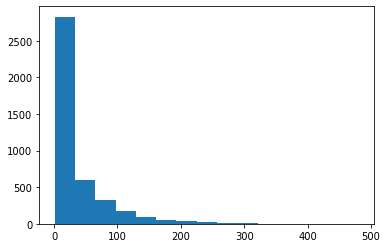

In [28]:
# Check for skewness amonst continuous data
plt.hist(X_sig[:,12], bins = 15, align='mid')
plt.show()

In [2]:
#Splitting the data into Training Set and Test Set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sig,y,test_size=0.3,random_state=0)

#Normalizing all features that are skewed
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train[:,[2,3,5,6,7,8,9,10,11,12,13]] = sc_X.fit_transform(X_train[:,[2,3,5,6,7,8,9,10,11,12,13]])   
X_test[:,[2,3,5,6,7,8,9,10,11,12,13]] = sc_X.transform(X_test[:,[2,3,5,6,7,8,9,10,11,12,13]])  #All the columns that are skewed

In [11]:
#######################################  Logistic Regression  ################################################

print(color.BOLD+'Logistic Regression'+color.END)
#Fitting Logistic Regression to Training Set
from sklearn.linear_model import LogisticRegression
classifierObj = LogisticRegression(random_state=0)
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  k-NN Model  ################################################

print(color.BOLD+'\nk-NN Model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.neighbors import KNeighborsClassifier
classifierObj = KNeighborsClassifier(n_neighbors=15, p=2, metric='minkowski')
classifierObj.fit(X_train, y_train)      

#Find Error rate (Misclassification rate)
print('Misclassification Rate with 15 neighbors: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  SVM Model  ################################################

print(color.BOLD+'\nSVM Model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.svm import SVC
classifierObj = SVC(kernel='rbf',random_state=0)
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f' % (1-classifierObj.score(X_test,y_test)))    # misclasification rate = 1- accuracy

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean())  


#######################################  Naïve Bayes model  ################################################
print(color.BOLD+'\nNaïve Bayes model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.naive_bayes import GaussianNB
classifierObj = GaussianNB()
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f' % (1-classifierObj.score(X_test,y_test)))    # misclasification rate = 1- accuracy

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  Decision Tree  ################################################

print(color.BOLD+'\nDecision Tree'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.tree import DecisionTreeClassifier
classifierObj = DecisionTreeClassifier(criterion='entropy',random_state=0)
classifierObj.fit(X_train,y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 

Logistic Regression
Misclassification Rate: 0.524 
K-Fold Model Accuracy: 0.497

k-NN Model
Misclassification Rate with 15 neighbors: 0.504 
K-Fold Model Accuracy: 0.496

SVM Model
Misclassification Rate: 0.484
K-Fold Model Accuracy: 0.526

Naïve Bayes model
Misclassification Rate: 0.550
K-Fold Model Accuracy: 0.454

Decision Tree
Misclassification Rate: 0.562 
K-Fold Model Accuracy: 0.433


In [20]:
#######################################  Random Forest - Grid Search  ################################################

print(color.BOLD+'\nRandom Forest model - Grid Search'+color.END)
from sklearn.ensemble import RandomForestClassifier
classifierObj = RandomForestClassifier(random_state=0)

grid_param = {  
    'n_estimators': [162,165,167,170,173,175,178],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

from sklearn.model_selection import GridSearchCV
gd_sr = GridSearchCV(estimator=classifierObj, param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr.fit(X_train, y_train) 
print(gd_sr.best_params_)  
print('%.3f' % gd_sr.best_score_)


Random Forest model - Grid Search
{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 170}
0.549


In [27]:
#######################################  Random Forest model  ################################################

print(color.BOLD+'\nRandom Forest model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.ensemble import RandomForestClassifier
classifierObj = RandomForestClassifier(n_estimators= 170,criterion='entropy',bootstrap='True',random_state=0)
classifierObj.fit(X_train,y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate with 50 trees: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 



Random Forest model
Misclassification Rate with 50 trees: 0.450 
K-Fold Model Accuracy: 0.558


In [16]:
#######################################  Logistic Regression  ################################################

print(color.BOLD+'Logistic Regression'+color.END)
#Fitting Logistic Regression to Training Set
from sklearn.linear_model import LogisticRegression
classifierObj = LogisticRegression(random_state=0)
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  k-NN Model  ################################################

print(color.BOLD+'\nk-NN Model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.neighbors import KNeighborsClassifier
classifierObj = KNeighborsClassifier(n_neighbors=15, p=2, metric='minkowski')
classifierObj.fit(X_train, y_train)      

#Find Error rate (Misclassification rate)
print('Misclassification Rate with 15 neighbors: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  SVM Model  ################################################

print(color.BOLD+'\nSVM Model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.svm import SVC
classifierObj = SVC(kernel='rbf',random_state=0)
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f' % (1-classifierObj.score(X_test,y_test)))    # misclasification rate = 1- accuracy

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean())  


#######################################  Naïve Bayes model  ################################################
print(color.BOLD+'\nNaïve Bayes model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.naive_bayes import GaussianNB
classifierObj = GaussianNB()
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f' % (1-classifierObj.score(X_test,y_test)))    # misclasification rate = 1- accuracy

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  Decision Tree  ################################################

print(color.BOLD+'\nDecision Tree'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.tree import DecisionTreeClassifier
classifierObj = DecisionTreeClassifier(criterion='entropy',random_state=0)
classifierObj.fit(X_train,y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 

Logistic Regression
Misclassification Rate: 0.526 
K-Fold Model Accuracy: 0.497

k-NN Model
Misclassification Rate with 15 neighbors: 0.505 
K-Fold Model Accuracy: 0.496

SVM Model
Misclassification Rate: 0.481
K-Fold Model Accuracy: 0.526

Naïve Bayes model
Misclassification Rate: 0.541
K-Fold Model Accuracy: 0.475

Decision Tree
Misclassification Rate: 0.595 
K-Fold Model Accuracy: 0.427


In [17]:
#######################################  Random Forest - Grid Search  ################################################

print(color.BOLD+'\nRandom Forest model - Grid Search'+color.END)
from sklearn.ensemble import RandomForestClassifier
classifierObj = RandomForestClassifier(random_state=0)

grid_param = {  
    'n_estimators': [10, 15, 20, 25, 30, 40, 50],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

from sklearn.model_selection import GridSearchCV
gd_sr = GridSearchCV(estimator=classifierObj, param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr.fit(X_train, y_train) 
print(gd_sr.best_params_)  
print(gd_sr.best_score_)


Random Forest model - Grid Search
{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 40}
0.5462068965517242


In [18]:
#######################################  Random Forest model  ################################################

print(color.BOLD+'\nRandom Forest model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.ensemble import RandomForestClassifier
classifierObj = RandomForestClassifier(n_estimators= 40,criterion='gini',bootstrap='True',random_state=0)
classifierObj.fit(X_train,y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate with 40 trees: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


Random Forest model
Misclassification Rate with 40 trees: 0.478 
K-Fold Model Accuracy: 0.531


C:\Users\Jingj\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


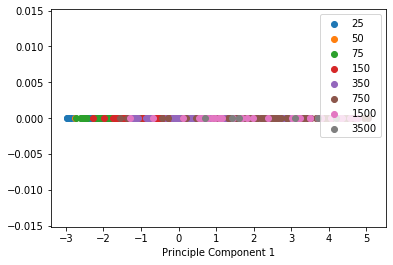

X_train shape after LDA:  (2900, 7)


In [19]:
#######################################  Apply LDA  ################################################

#Splitting the data into Training Set and Test Set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sig,y,test_size=0.3,random_state=0)

#Normalizing all features that are skewed
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train[:,[2,3,5,6,7,8,9,10,11,12,13]] = sc_X.fit_transform(X_train[:,[2,3,5,6,7,8,9,10,11,12,13]])
X_test[:,[2,3,5,6,7,8,9,10,11,12,13]] = sc_X.transform(X_test[:,[2,3,5,6,7,8,9,10,11,12,13]]) 

#Applying LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
ldaObj = LDA(n_components=None, solver='svd')          #Specifying 'None' makes n_components = min(n_classes - 1, n_features)
X_train = ldaObj.fit_transform(X_train,y_train)
X_test = ldaObj.transform(X_test)

#Visualizing the data
X_set, y_set = X_test, y_test
y_axis = np.zeros((1243,1))
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0],  y_axis[y_set == j, 0],
                cmap='Blues', label = j)
plt.xlabel('Principle Component 1')
plt.ylabel('')
plt.legend()
plt.show()
print('X_train shape after LDA: ', X_train.shape)

In [20]:
#######################################  Logistic Regression  ################################################

print(color.BOLD+'Logistic Regression'+color.END)
#Fitting Logistic Regression to Training Set
from sklearn.linear_model import LogisticRegression
classifierObj = LogisticRegression(random_state=0)
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  k-NN Model  ################################################

print(color.BOLD+'\nk-NN Model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.neighbors import KNeighborsClassifier
classifierObj = KNeighborsClassifier(n_neighbors=15, p=2, metric='minkowski')
classifierObj.fit(X_train, y_train)      

#Find Error rate (Misclassification rate)
print('Misclassification Rate with 15 neighbors: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  SVM Model  ################################################

print(color.BOLD+'\nSVM Model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.svm import SVC
classifierObj = SVC(kernel='rbf',random_state=0)
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f' % (1-classifierObj.score(X_test,y_test)))    # misclasification rate = 1- accuracy

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean())  


#######################################  Naïve Bayes model  ################################################
print(color.BOLD+'\nNaïve Bayes model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.naive_bayes import GaussianNB
classifierObj = GaussianNB()
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f' % (1-classifierObj.score(X_test,y_test)))    # misclasification rate = 1- accuracy

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  Decision Tree  ################################################

print(color.BOLD+'\nDecision Tree'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.tree import DecisionTreeClassifier
classifierObj = DecisionTreeClassifier(criterion='entropy',random_state=0)
classifierObj.fit(X_train,y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 

Logistic Regression
Misclassification Rate: 0.536 
K-Fold Model Accuracy: 0.493

k-NN Model
Misclassification Rate with 15 neighbors: 0.523 
K-Fold Model Accuracy: 0.490

SVM Model
Misclassification Rate: 0.507
K-Fold Model Accuracy: 0.509

Naïve Bayes model
Misclassification Rate: 0.538
K-Fold Model Accuracy: 0.469

Decision Tree
Misclassification Rate: 0.587 
K-Fold Model Accuracy: 0.419


In [21]:
#######################################  Random Forest - Grid Search  ################################################

print(color.BOLD+'\nRandom Forest model - Grid Search'+color.END)
from sklearn.ensemble import RandomForestClassifier
classifierObj = RandomForestClassifier(random_state=0)

grid_param = {  
    'n_estimators': [10, 15, 20, 25, 30, 40, 50],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

from sklearn.model_selection import GridSearchCV
gd_sr = GridSearchCV(estimator=classifierObj, param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr.fit(X_train, y_train) 
print(gd_sr.best_params_)  
print(gd_sr.best_score_)


Random Forest model - Grid Search
{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 50}
0.5210344827586207


In [22]:
#######################################  Random Forest model  ################################################

print(color.BOLD+'\nRandom Forest model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.ensemble import RandomForestClassifier
classifierObj = RandomForestClassifier(n_estimators=50,criterion='gini',bootstrap='True',random_state=0)
classifierObj.fit(X_train,y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate with 50 trees: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


Random Forest model
Misclassification Rate with 40 trees: 0.513 
K-Fold Model Accuracy: 0.515


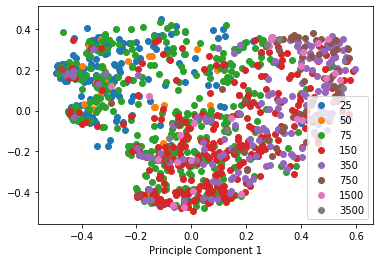

X_train shape after Kernel PCA:  (2900, 16)


In [23]:
#######################################  Apply Kernel PCA  ################################################

#Splitting the data into Training Set and Test Set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sig,y,test_size=0.3,random_state=0)

#Normalizing all features that are skewed
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train[:,[2,3,5,6,7,8,9,10,11,12,13]] = sc_X.fit_transform(X_train[:,[2,3,5,6,7,8,9,10,11,12,13]])
X_test[:,[2,3,5,6,7,8,9,10,11,12,13]] = sc_X.transform(X_test[:,[2,3,5,6,7,8,9,10,11,12,13]]) 

#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=16, kernel='rbf',remove_zero_eig=True,random_state=0)
X_train = kernelPCAObj.fit_transform(X_train)
X_test = kernelPCAObj.transform(X_test)

# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                cmap='jet', label = j)
plt.xlabel('Principle Component 1')
plt.ylabel('')
plt.legend()
plt.show()
print('X_train shape after Kernel PCA: ', X_train.shape)

In [24]:
#######################################  Logistic Regression  ################################################

print(color.BOLD+'Logistic Regression'+color.END)
#Fitting Logistic Regression to Training Set
from sklearn.linear_model import LogisticRegression
classifierObj = LogisticRegression(random_state=0)
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  k-NN Model  ################################################

print(color.BOLD+'\nk-NN Model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.neighbors import KNeighborsClassifier
classifierObj = KNeighborsClassifier(n_neighbors=15, p=2, metric='minkowski')
classifierObj.fit(X_train, y_train)      

#Find Error rate (Misclassification rate)
print('Misclassification Rate with 15 neighbors: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  SVM Model  ################################################

print(color.BOLD+'\nSVM Model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.svm import SVC
classifierObj = SVC(kernel='rbf',random_state=0)
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f' % (1-classifierObj.score(X_test,y_test)))    # misclasification rate = 1- accuracy

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean())  


#######################################  Naïve Bayes model  ################################################
print(color.BOLD+'\nNaïve Bayes model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.naive_bayes import GaussianNB
classifierObj = GaussianNB()
classifierObj.fit(X_train, y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f' % (1-classifierObj.score(X_test,y_test)))    # misclasification rate = 1- accuracy

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


#######################################  Decision Tree  ################################################

print(color.BOLD+'\nDecision Tree'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.tree import DecisionTreeClassifier
classifierObj = DecisionTreeClassifier(criterion='entropy',random_state=0)
classifierObj.fit(X_train,y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 

Logistic Regression
Misclassification Rate: 0.516 
K-Fold Model Accuracy: 0.506

k-NN Model
Misclassification Rate with 15 neighbors: 0.521 
K-Fold Model Accuracy: 0.489

SVM Model
Misclassification Rate: 0.538
K-Fold Model Accuracy: 0.490

Naïve Bayes model
Misclassification Rate: 0.539
K-Fold Model Accuracy: 0.461

Decision Tree
Misclassification Rate: 0.579 
K-Fold Model Accuracy: 0.427


In [14]:
#######################################  Random Forest - Grid Search  ################################################

print(color.BOLD+'\nRandom Forest model - Grid Search'+color.END)
from sklearn.ensemble import RandomForestClassifier
classifierObj = RandomForestClassifier(random_state=0)

grid_param = {  
    'n_estimators': [10, 15, 20, 25, 30, 40, 50,70,90,110,130,150,170],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

from sklearn.model_selection import GridSearchCV
gd_sr = GridSearchCV(estimator=classifierObj, param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr.fit(X_train, y_train) 
print(gd_sr.best_params_)  
print(gd_sr.best_score_)


Random Forest model - Grid Search
{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 170}
0.5486206896551724


In [15]:
#######################################  Random Forest model  ################################################

print(color.BOLD+'\nRandom Forest model'+color.END)
#Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
from sklearn.ensemble import RandomForestClassifier
classifierObj = RandomForestClassifier(n_estimators= 170,criterion='entropy',bootstrap='True',random_state=0)
classifierObj.fit(X_train,y_train)

#Find Error rate (Misclassification rate)
print('Misclassification Rate with 40 trees: %.3f ' % (1-classifierObj.score(X_test,y_test)))

#K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
modelAccuracies = cross_val_score(estimator=classifierObj, X=X_train, y=y_train, cv=10)
print('K-Fold Model Accuracy: %.3f' % modelAccuracies.mean()) 


Random Forest model
Misclassification Rate with 40 trees: 0.450 
K-Fold Model Accuracy: 0.558


In [ ]:
#This is here because it would look messy if I included this in the main part
#These are the for loops that you can use to find the optimal number of components/trees/etc

#######################################  k-NN  ################################################
x_axis = np.arange(2,21)
y_axis = np.ones(19)
i = 0

for k in range(2,21):
    #Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
    from sklearn.neighbors import KNeighborsClassifier
    classifierObj = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    classifierObj.fit(X_train, y_train)           # Find optimal k based on train data

    #Find Error rate (Misclassification rate)
    print('%.3f ' % (1-classifierObj.score(X_test,y_test)),k, sep='\t')    # misclasification rate = 1- accuracy
    y_axis[i] = 1-classifierObj.score(X_test,y_test)
    i = i+1

#plot the data    
plt.scatter(x_axis,y_axis)
plt.title('kNN (Training set)')
plt.xlabel('k')
plt.ylabel('error (misclassification) rate')
plt.show()

#######################################  Random Forest model Find # trees  ################################################
x_axis = np.arange(10,31)
y_axis = np.ones(21)
i = 0

for trees in range(10,31):
    #Fitting Classifier to Training Set. Create a classifier object here and call it classifierObj
    from sklearn.ensemble import RandomForestClassifier
    classifierObj = RandomForestClassifier(n_estimators= trees,criterion='entropy',random_state=0)
    classifierObj.fit(X_train,y_train)
    
    #Making predictions on the Test Set
    y_pred = classifierObj.predict(X_test)
    
    #Find Error rate (Misclassification rate)
    print('%.4f ' % (1-classifierObj.score(X_test,y_test)), trees, sep='\t')
    y_axis[i] = 1-classifierObj.score(X_test,y_test)
    i = i+1

#plot the data    
plt.scatter(x_axis,y_axis)
plt.xlabel('trees')
plt.ylabel('error (misclassification) rate')
plt.show()
